## Exploring the neighborhoods & Boroughs in New-York City that are the best equipped to fight the Covid-19 Pandemic.

### Step 1: Import all the required libraries.

In [1]:
! pip install geocoder
! pip install folium
! pip install selenium
! pip install fuzzywuzzy
import os
import webbrowser
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geocoder
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import sklearn
from sklearn.cluster import KMeans
import folium
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
import time
from fuzzywuzzy import fuzz

     |████████████████████████████████| 102kB 19.0MB/s ta 0:00:01
     |████████████████████████████████| 102kB 8.8MB/s ta 0:00:011
     |████████████████████████████████| 911kB 23.3MB/s eta 0:00:01


/opt/conda/envs/Python36/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Step 2: Get the NYC dataset and store it in a dataframe.

In [2]:
def get_new_york_data():
    NY_DATASET = "https://cocl.us/new_york_dataset"
    resp = requests.get(NY_DATASET).json()
    features = resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
    new_york_data = pd.DataFrame(columns=column_names)

    for data in features:
        borough = data['properties']['borough']
        neighborhood_name = data['properties']['name']

        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        new_york_data = new_york_data.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)

    return new_york_data

In [3]:
ny_set=get_new_york_data()
ny_set.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Step 3: Let use the Beautifulsoup to scrap data from Wikipedia page to get the NY Boroughs.

In [4]:
def get_population_per_neighbourhood(read_from_csv=False):
    if not read_from_csv:
        WIKI_LINK = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
        ROOT_WIKI_LINK = "https://en.wikipedia.org"
        page = requests.get(WIKI_LINK)
        soup = BeautifulSoup(page.text, 'html.parser')
        population_list = []
        for table_row in soup.select("table.wikitable tr"):
            cells = table_row.findAll('td')
            if len(cells) > 0:
                borough = cells[0].text.strip().replace(
                    '\xa0', ' ').split(' ')[0]
                population = int(cells[3].text.strip().replace(',', ''))
                for item in cells[4].findAll('a'):
                    neighborhood = item.text
                    neighbourhood_page = requests.get(
                        ROOT_WIKI_LINK+item['href'])
                    soup = BeautifulSoup(
                        neighbourhood_page.text, 'html.parser')
                    table = soup.select("table.infobox tr")
                    should_record = False
                    for row in table:
                        head = row.find('th')
                        body = row.find('td')
                        if head and 'population' in head.text.lower():
                            should_record = True
                            continue
                        if should_record:
                            try:
                                population_list.append(
                                    [borough, neighborhood, int(body.text.replace(',', ''))])
                            except:
                                pass
                            should_record = False
        df = pd.DataFrame(population_list, columns=[
                          "Borough", "Neighborhood", "Population"])
        df.to_csv('population.csv')
    else:
        df = pd.read_csv('population.csv')
    df = df.sort_values(by=['Borough'])
    df = df.drop_duplicates(subset='Neighborhood', keep='last')
    return df

In [5]:
ny_pop = get_population_per_neighbourhood()
ny_pop.head()

,Borough,Neighborhood,Population
0,Bronx,Melrose,24913
25,Bronx,Bruckner,38557
26,Bronx,Castle Hill,38557
27,Bronx,Clason Point,9136
28,Bronx,Harding Park,9136


### Step 4: Let combine the 2 dataframes containing Neighborhoods and Boroughs.

In [6]:
ny_set.set_index('Neighborhood')
ny_pop.set_index('Neighborhood')
nyc = pd.merge(ny_set, ny_pop, how="inner", on=["Borough", "Neighborhood"])
nyc.head()

,Borough,Neighborhood,Latitude,Longitude,Population
0,Bronx,Wakefield,40.894705,-73.847201,29158
1,Bronx,Co-op City,40.874294,-73.829939,43752
2,Bronx,Fieldston,40.895437,-73.905643,3292
3,Bronx,Riverdale,40.890834,-73.912585,48049
4,Bronx,Kingsbridge,40.881687,-73.902818,10669


### _We can see how many Boroughs and Neighborhoods are included in the dataframe._

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc['Borough'].unique()),
        nyc.shape[0]
    )
)

The dataframe has 4 boroughs and 141 neighborhoods.


### We can visualize the Population Per Neighborhoods on a Folium Map: click on a dot on the map to see the neighborhood name and its population !

In [8]:
import folium # map rendering library
map_nyc = folium.Map(location=[40.730610,-73.935242], zoom_start=11)

for lat, lon, neighborhood, population in zip(nyc['Latitude'], nyc['Longitude'], nyc['Neighborhood'], nyc['Population']):
    folium.CircleMarker(
        [lat, lon],
        radius=0,
        popup = ('Neighborhood: ' + str(neighborhood).capitalize() + '<br>'
                 'Population: ' + str(population) + '<br>'),
        color='b',
        fill_color='red',
        key_on = population,
        threshold_scale=[0,1,2,3],
        fill=True,
        fill_opacity=0.7
        ).add_to(map_nyc)
map_nyc

### Let display and visualize the Population/Borough.

In [9]:
nyc_borough=nyc.groupby(['Borough'])['Population'].sum()
nyc_borough.head()

Borough
Bronx        1030645
Brooklyn     2409467
Manhattan    1486691
Queens       1915215
Name: Population, dtype: int64

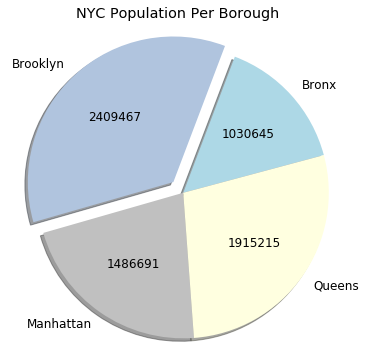

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

Population = [1030645, 2409467, 1486691, 1915215]

my_labels = 'Bronx','Brooklyn','Manhattan','Queens'
my_colors = ['lightblue','lightsteelblue','silver', 'lightyellow']
my_explode = (0, 0.1, 0, 0)
fig = plt.figure(1, figsize=(6,6))
mpl.rcParams['font.size'] = 12
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format
plt.pie(Population, labels=my_labels, autopct = autopct_format(Population), startangle=15, shadow = True, colors=my_colors, explode=my_explode)
plt.title('NYC Population Per Borough')
plt.axis('equal')
plt.show()

In [11]:
nyc_nbh=nyc.groupby(['Borough'])['Neighborhood'].count()
nyc_nbh.head()

Borough
Bronx        34
Brooklyn     37
Manhattan    23
Queens       47
Name: Neighborhood, dtype: int64

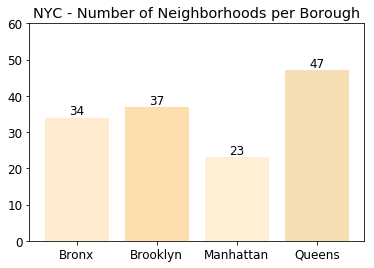

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

bar_x = [1,2,3,4]
bar_height = [34, 37, 23, 47]
bar_tick_label = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens']
bar_label = [34, 37, 23, 47]

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)

plt.ylim(0,60)
plt.bar (bar_x, bar_height, color=['blanchedalmond','navajowhite', 'papayawhip', 'wheat'])
plt.title('NYC - Number of Neighborhoods per Borough')

plt.show()

### Step 5: Now, we are going to get the hospitals data using the Fourthsquare API.

In [13]:
def hospital_data(lat, lng, borough, neighborhood):
    radius = 1000
    LIMIT = 100
    VERSION = '20200328'
    FS_CLIENT_ID = "1H2QWFULVORDMP4RY2WQQNCOUEPAAZJ2EJS2HQNMRURL3J4O"
    FS_CLIENT_SECRET = "DGWJO5LXLYWAIAQZOWZKIQ4I3MHXQLQ23GWC2C14O0TRUFI5"
    FS_HOSPITAL_KEY = "4bf58dd8d48988d196941735"
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FS_CLIENT_ID,
        FS_CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT,
        FS_HOSPITAL_KEY)
    response = requests.get(url)
    if not response.status_code == 200:
        print("ERROR", response.status_code, response.content)
        return None
    results = response.json()
    venue_data = results["response"]["venues"]
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['id']
            venue_name = row['name']
            lat = row["location"]["lat"]
            lng = row["location"]["lng"]
            venue_details.append(
                [venue_id, venue_name, lat, lng, borough, neighborhood])
        except KeyError:
            pass

    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    df_hosp = pd.DataFrame(venue_details, columns=column_names)
    return df_hosp

In [14]:
#Now we will write a code to integrate the hospital data from Foursquare into the NYC dataframe with neighborhoods
def hospital_per_neighborhood_borough(df_hosp):
    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    data = []
    for i, row in df_hosp.iterrows():
        h_df = hospital_data(
            row["Latitude"], row["Longitude"], row["Borough"], row["Neighborhood"])
        if h_df is not None:
            for x, hrow in h_df.iterrows():
                data.append([hrow[column] for column in column_names])

    df_hospnyc = pd.DataFrame(data, columns=column_names)
    df_hospnyc.to_csv('hospital_per_boro_nei.csv')
    return df_hospnyc

In [15]:
# We can display the dataframe with hospitals and neighborhoods
hospital_df = hospital_per_neighborhood_borough(nyc)
hospital_df.head()

,ID,Name,Latitude,Longitude,Borough,Neighborhood
0,59832a7bfe37406ea7eb3a79,Statcare Urgent & Walk-In Medical Care (Bronx ...,40.870168,-73.828404,Bronx,Co-op City
1,50173409e4b0cfe38c43abf4,wellcare,40.874247,-73.837745,Bronx,Co-op City
2,568e86f5498ec6df53771448,CityMD Baychester Urgent Care - Bronx,40.866795,-73.827051,Bronx,Co-op City
3,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888478,-73.910047,Bronx,Fieldston
4,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888478,-73.910047,Bronx,Riverdale


### _We can view the hospitals on a map._

In [16]:
import folium # map rendering library
map_nyc = folium.Map(location=[40.730610,-73.935242], zoom_start=11)

for lat, lon, name in zip(hospital_df['Latitude'], hospital_df['Longitude'], hospital_df['Name']):
    folium.CircleMarker(
        [lat, lon],
        radius=0,
        popup = ('Name: ' + str(name).capitalize() + '<br>'),
        color='b',
        fill_color='green',
        key_on = name,
        threshold_scale=[0,1,2,3],
        fill=True,
        fill_opacity=0.7
        ).add_to(map_nyc)
map_nyc

### Step 6: Get the hospital-beds data that I have combined in a CSV file and put on my GitHub.

In [17]:
import pandas as pd
url = 'https://raw.githubusercontent.com/ljulienne/Coursera_Capstone/master/beds_hospital.csv'
beds_hosp = pd.read_csv(url, error_bad_lines=False)

In [18]:
beds_hosp.head()

,Hospital Name,Bed Number,ICU Bed Number
0,Jamaica Hospital Medical Center,402,8
1,"New York Community Hospital of Brooklyn, Inc",134,7
2,Mount Sinai Hospital,1134,85
3,Nassau University Medical Center,530,22
4,Richmond University Medical Center,448,20


### Step 7: Combine the hospital-beds with the Boroughs and Neighborhoods.

In [19]:
def hosp_beds_bor_nbh(hospital_df, beds_hosp):
    data = []
    column_names = ["Hospital Name", "Bed Number", "ICU Bed Number"]
    boro_neig_column_names = ["Borough", "Neighborhood"]
    for i, row in beds_hosp.iterrows():
        data_per_hospital = None
        max_ratio = 0
        for x, hrow in hospital_df.iterrows():
            ratio = fuzz.token_sort_ratio(row["Hospital Name"], hrow["Name"])
            if ratio > max_ratio:
                max_ratio = ratio
                data_per_hospital = [
                    row[column] for column in column_names] + \
                    [hrow[column] for column in boro_neig_column_names
                     ]
        if data_per_hospital:
            data.append(data_per_hospital)

    df = pd.DataFrame(data, columns=column_names+boro_neig_column_names)
    df.to_csv('cleaned_hospital_data.csv')
    return df

In [20]:
hosp_beds_br_nbh = hosp_beds_bor_nbh(hospital_df, beds_hosp)
hosp_beds_br_nbh.head()

,Hospital Name,Bed Number,ICU Bed Number,Borough,Neighborhood
0,Jamaica Hospital Medical Center,402,8,Queens,Briarwood
1,"New York Community Hospital of Brooklyn, Inc",134,7,Brooklyn,Fort Greene
2,Mount Sinai Hospital,1134,85,Manhattan,Yorkville
3,Nassau University Medical Center,530,22,Bronx,University Heights
4,Richmond University Medical Center,448,20,Bronx,University Heights


### Step 8: Now, we can make a new dataframe to view the total number of Beds and ICU Beds Per Neighborhood and Borough.

In [21]:
hosp_beds_br_nbh.dtypes
hosp_beds_br_nbh = hosp_beds_br_nbh.astype({'Bed Number': 'int32', 'ICU Bed Number': 'int32'})
hosp_beds_br_nbh = hosp_beds_br_nbh.groupby(
    ["Neighborhood", "Borough"]
).agg(
    {
        "Bed Number": "sum",
        "ICU Bed Number": "sum"
    }
)
hosp_beds_br_nbh.head()

,,Bed Number,ICU Bed Number
Neighborhood,Borough,,
Bensonhurst,Brooklyn,204,8
Briarwood,Queens,671,24
Brighton Beach,Brooklyn,306,17
Brownsville,Brooklyn,600,28
Bushwick,Brooklyn,324,16


In [22]:
total_beds_borough=hosp_beds_br_nbh.groupby(['Borough'])['Bed Number'].sum()
total_beds_borough.head()

Borough
Bronx         5816
Brooklyn      7371
Manhattan    11288
Queens        3902
Name: Bed Number, dtype: int32

In [23]:
total_icubeds_borough=hosp_beds_br_nbh.groupby(['Borough'])['ICU Bed Number'].sum()
total_icubeds_borough.head()

Borough
Bronx        315
Brooklyn     469
Manhattan    766
Queens       201
Name: ICU Bed Number, dtype: int32

### _Let visualize the number of bed types in each Borough._

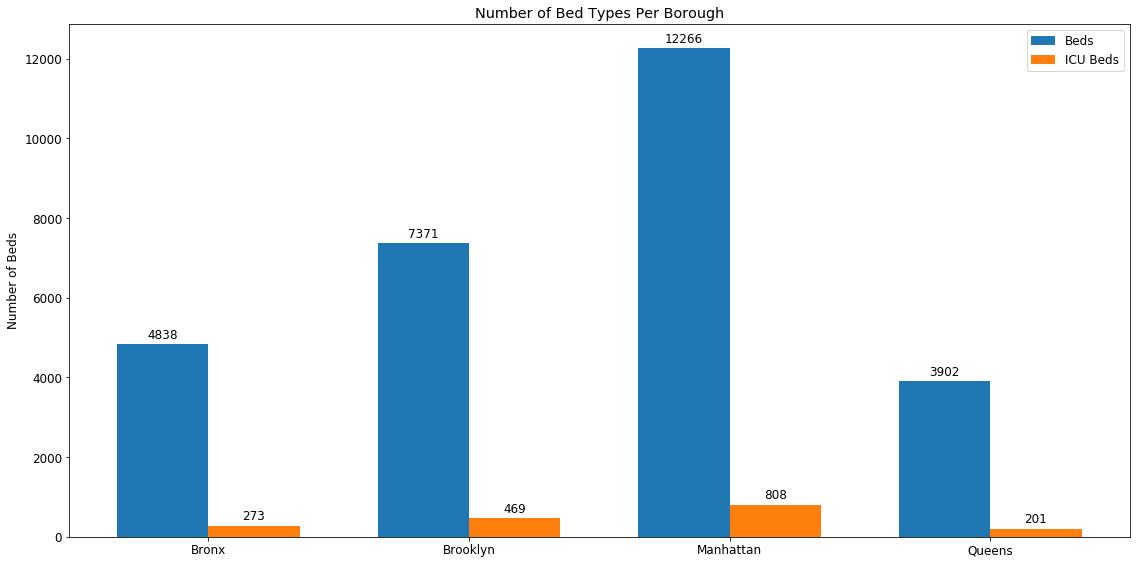

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens']
Beds = [4838,7371,12266,3902]
ICU_Beds = [273,469,808,201]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, Beds, width, label='Beds')
rects2 = ax.bar(x + width/2, ICU_Beds, width, label='ICU Beds')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Beds')
ax.set_title('Number of Bed Types Per Borough')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Step 9: Combine the New-York City Population data with the number of beds.

In [25]:
df_beds_pop = pd.merge(hosp_beds_br_nbh, nyc, how="inner", on=["Borough", "Neighborhood"])
df_beds_pop.head()

,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population
0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705
1,Queens,Briarwood,671,24,40.710935,-73.811748,53877
2,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547
3,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300
4,Brooklyn,Bushwick,324,16,40.698116,-73.925258,129239


### Step 10: We add two new columns to get the beds per thousand people, for Beds and ICU Beds.

In [26]:
def beds_thousand_people(row, field="Bed Number"):
    return row[field] * 1000 / row["Population"]

df_beds_pop["ICU Bed Per Thousand People"] = df_beds_pop.apply(
    lambda row: beds_thousand_people(row, field="ICU Bed Number"), axis=1)

df_beds_pop["Bed Per Thousand People"] = df_beds_pop.apply(
    lambda row: beds_thousand_people(row), axis=1)

df_beds_pop.head()

,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Thousand People,Bed Per Thousand People
0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.052734,1.344715
1,Queens,Briarwood,671,24,40.710935,-73.811748,53877,0.445459,12.454294
2,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547,0.478240,8.608321
3,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300,0.480274,10.291595
4,Brooklyn,Bushwick,324,16,40.698116,-73.925258,129239,0.123802,2.506983


### _We can represent the ICU Beds Per Hundred People as well as the Beds Per Hundred People (Per Neighborhood) on Bar Charts._

In [27]:
def show_bar_chart(df, group, field, title, x_label, y_label, calculation="sum"):
    
    plt.figure(figsize=(9, 5), dpi=100)
    plt.title(title)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    if calculation == "sum":
        df_beds_pop.groupby(group)[field].sum().plot(kind='bar')
    if calculation == "count":
        df_beds_pop.groupby(group)[field].count().plot(kind='bar')
    plt.legend()
    plt.show()

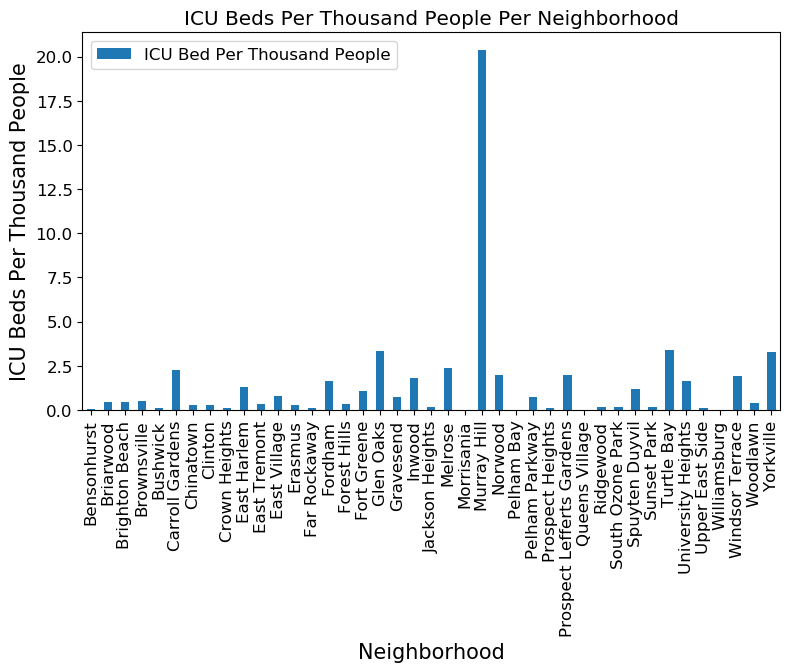

In [28]:
show_bar_chart(df_beds_pop, group="Neighborhood", field="ICU Bed Per Thousand People", title="ICU Beds Per Thousand People Per Neighborhood",  x_label="Neighborhood", y_label="ICU Beds Per Thousand People")

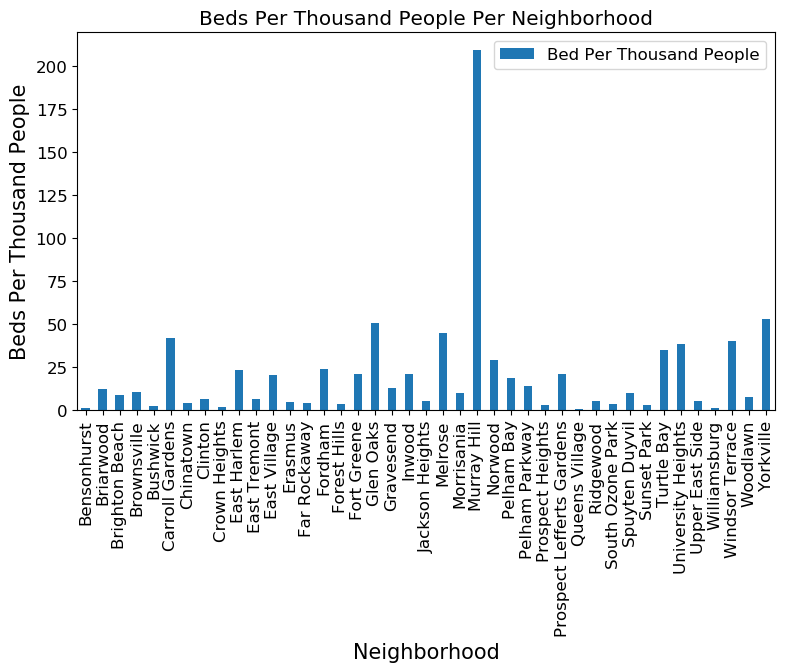

In [29]:
show_bar_chart(df_beds_pop, group="Neighborhood", field="Bed Per Thousand People", title="Beds Per Thousand People Per Neighborhood",  x_label="Neighborhood", y_label="Beds Per Thousand People")

### Step 11: Let prepare data for K-Means Clustering.

In [30]:
df_clusters = df_beds_pop.drop(['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'ICU Bed Number', 'Bed Number'],axis = 1)

In [31]:
# Now we are going to use k-means clustering to partition data in k partitions
# We are going to use elbow method to find the optimum number of cluster

def plot_kmeans(dataset):
    obs = dataset.copy()
    silhouette_score_values = list()
    number_of_clusters = range(3, 30)
    for i in number_of_clusters:
        classifier = KMeans(i, init='k-means++', n_init=10,
                            max_iter=300, tol=0.0001, random_state=10)
        classifier.fit(obs)
        labels = classifier.predict(obs)
        silhouette_score_values.append(sklearn.metrics.silhouette_score(
            obs, labels, metric='euclidean', random_state=0))

    plt.plot(number_of_clusters, silhouette_score_values)
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.show()

    optimum_number_of_components = number_of_clusters[silhouette_score_values.index(
        max(silhouette_score_values))]
    print("Optimal number of components is:")
    print(optimum_number_of_components)

In [32]:
# Normalizing data
df_clusters = sklearn.preprocessing.StandardScaler().fit_transform(df_clusters)
df_clusters

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 2.28695211e+00, -4.18214236e-01, -5.73171055e-01],
       [-1.56803924e-01, -2.93720798e-01, -2.38605342e-01],
       [-6.14689683e-01, -2.83329265e-01, -3.54427066e-01],
       [-4.63168143e-02, -2.82684374e-01, -3.03735162e-01],
       [ 1.72574854e+00, -3.95685851e-01, -5.38169273e-01],
       [-1.18158872e+00,  2.80308206e-01,  6.39858069e-01],
       [-3.07509040e-01, -3.48797035e-01, -5.00367515e-01],
       [-3.56470092e-01, -3.52026409e-01, -4.19393423e-01],
       [ 2.06950009e+00, -4.06112752e-01, -5.53226511e-01],
       [ 1.39306318e+00, -2.20045284e-02,  8.23090220e-02],
       [-4.17946189e-01, -3.32727293e-01, -4.18092340e-01],
       [ 7.97578953e-02, -1.89726720e-01,  2.44917789e-03],
       [ 1.88512176e+00, -3.50783629e-01, -4.82431907e-01],
       [-2.97629095e-03, -3.92688956e-01, -4.84749572e-01],
       [-4.18670613e-01,  7.64283697e-02,  1.00450008e-01],
       [ 5.88877899e-01, -3.28921271e-01, -5.01447900e-01],
       [-7.94846371e-01, -8.81171700e-02

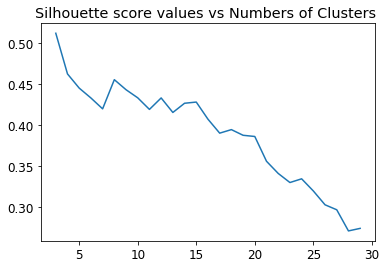

Optimal number of components is:
3


In [33]:
plot_kmeans(df_clusters)

In [34]:
# From previously, we get the best value for k = 3
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:24]

array([0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2,
       2, 1], dtype=int32)

### Now, we combine the clusters data in the dataframe.

In [35]:
# Combining cluster labels with dataframe
df_beds_pop.insert(0, 'Cluster Labels', kmeans.labels_)

In [36]:
df_beds_pop.head()

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Thousand People,Bed Per Thousand People
0,0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.052734,1.344715
1,2,Queens,Briarwood,671,24,40.710935,-73.811748,53877,0.445459,12.454294
2,2,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547,0.478240,8.608321
3,2,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300,0.480274,10.291595
4,0,Brooklyn,Bushwick,324,16,40.698116,-73.925258,129239,0.123802,2.506983


In [37]:
def get_geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location:
        latitude = location.latitude
        longitude = location.longitude
        return [latitude, longitude]
    return [None, None]
def save_map(m, filepath='map.html'):
    m.save(filepath)

def render_map_clusters(df_beds_pop, df_clusters, bpp_df=df_clusters[:, 1],kclusters=3, m_boost=5, add_boost=5):
    """
    This function will render map for dataframe using folium
    """
    map_clusters = folium.Map(
        location=get_geo_location("New York"), zoom_start=11)
    colours = ['red', 'black', 'blue']
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    markers_colors = []
    for lat, lon, poi, nei, cluster, bed_per_people in zip(df_beds_pop['Latitude'], df_beds_pop['Longitude'], df_beds_pop['Borough'], df_beds_pop["Neighborhood"], df_beds_pop['Cluster Labels'], bpp_df):
        label = folium.Popup(
            ' Cluster ' + str(cluster)+': ' + str(poi) + "-" + str(nei),
            parse_html=True
        )
        folium.CircleMarker(
            [lat, lon],
            radius=bed_per_people*m_boost+add_boost,
            popup=label,
            color=colours[cluster],
            fill=True,
            fill_color=colours[cluster],
            fill_opacity=0.7).add_to(map_clusters)
    return map_clusters

In [38]:
# Now let us render the map
map_clusters = render_map_clusters(df_beds_pop, df_clusters)
map_clusters
save_map(map_clusters)

In [39]:
map_clusters

In [40]:
# Now let us render the map for bed per thousand people
map_clusters = render_map_clusters(df_beds_pop, df_clusters,df_beds_pop['Bed Per Thousand People'],m_boost=1,add_boost=5)
map_clusters

In [41]:
# Now let us render the map for ICU bed per Thousand people
map_clusters = render_map_clusters(df_beds_pop, df_clusters,df_beds_pop['ICU Bed Per Thousand People'],m_boost=2,add_boost=5)
map_clusters

### We can visualize the clusters and their centroids on a scatter plot.

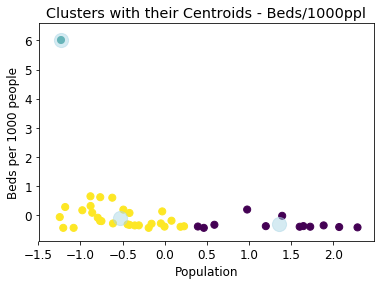

In [42]:
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='lightblue', s=200, alpha=0.5)
plt.title('Clusters with their Centroids - Beds/1000ppl')
plt.xlabel('Population')
plt.ylabel('Beds per 1000 people')
plt.show()

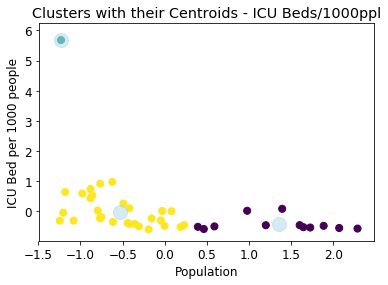

In [43]:
# Scatter plot for ICU bed per 1000 people

y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 2], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='lightblue', s=200, alpha=0.5);
plt.title('Clusters with their Centroids - ICU Beds/1000ppl')
plt.xlabel('Population')
plt.ylabel('ICU Bed per 1000 people')
plt.show()

### Now let view the dataframe with each cluster.

In [44]:
# Dataframe for Cluster 0.
df_beds_pop[(df_beds_pop['Cluster Labels'] == 0)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Thousand People,Bed Per Thousand People
0,0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.052734,1.344715
4,0,Brooklyn,Bushwick,324,16,40.698116,-73.925258,129239,0.123802,2.506983
8,0,Brooklyn,Crown Heights,287,13,40.670829,-73.943291,143000,0.090909,2.006993
9,0,Manhattan,East Harlem,2679,151,40.792249,-73.944182,115921,1.302611,23.110567
12,0,Brooklyn,Erasmus,591,36,40.646926,-73.948177,135619,0.265450,4.357796
15,0,Queens,Forest Hills,312,28,40.725264,-73.844475,83728,0.334416,3.726352
20,0,Queens,Jackson Heights,545,20,40.751981,-73.882821,108152,0.184925,5.039204
28,0,Brooklyn,Prospect Lefferts Gardens,2080,197,40.658420,-73.954899,99287,1.984147,20.949369
31,0,Queens,South Ozone Park,247,11,40.668550,-73.809865,75878,0.144970,3.255225
33,0,Brooklyn,Sunset Park,364,24,40.645103,-74.010316,126000,0.190476,2.888889


In [45]:
# Dataframe for Cluster 1.
df_beds_pop[(df_beds_pop['Cluster Labels'] == 1)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Thousand People,Bed Per Thousand People
23,1,Manhattan,Murray Hill,2270,221,40.748303,-73.978332,10864,20.342415,208.946981


In [46]:
# Dataframe for Cluster 2.
df_beds_pop[(df_beds_pop['Cluster Labels'] == 2)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Thousand People,Bed Per Thousand People
1,2,Queens,Briarwood,671,24,40.710935,-73.811748,53877,0.445459,12.454294
2,2,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547,0.478240,8.608321
3,2,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300,0.480274,10.291595
5,2,Brooklyn,Carroll Gardens,535,29,40.680540,-73.994654,12853,2.256283,41.624523
6,2,Manhattan,Chinatown,180,13,40.715618,-73.994279,47844,0.271716,3.762227
7,2,Manhattan,Clinton,296,12,40.759101,-73.996119,45884,0.261529,6.451050
10,2,Bronx,East Tremont,282,14,40.842696,-73.887356,43423,0.322410,6.494254
11,2,Manhattan,East Village,1296,49,40.727847,-73.982226,63347,0.773517,20.458743
13,2,Queens,Far Rockaway,257,8,40.603134,-73.754980,60035,0.133256,4.280836
14,2,Bronx,Fordham,1029,70,40.860997,-73.896427,43394,1.613126,23.712956


In [47]:
# Let us see neighborhoods which does not have any hospitals
no_hosp = pd.merge(nyc, df_beds_pop, how='outer', indicator=True, on=["Borough", "Neighborhood"])
no_hosp = no_hosp.loc[no_hosp._merge == 'left_only', ["Borough", "Neighborhood"]]
no_hosp

,Borough,Neighborhood
0,Bronx,Wakefield
1,Bronx,Co-op City
2,Bronx,Fieldston
3,Bronx,Riverdale
4,Bronx,Kingsbridge
7,Bronx,Williamsbridge
8,Bronx,Baychester
10,Bronx,Bedford Park
12,Bronx,Morris Heights
15,Bronx,West Farms


#### _Let see which Boroughs have the highest number of  Neighborhoods without Hospital._

In [48]:
df = no_hosp['Borough'].value_counts().reset_index()
df.columns = ['Borough', 'count']
print (df)

     Borough  count
0     Queens     39
1      Bronx     24
2   Brooklyn     23
3  Manhattan     14


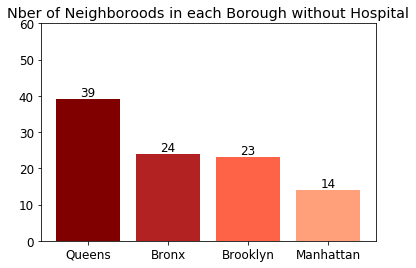

In [49]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

bar_x = [1,2,3,4]
bar_height = [39,24,23,14]
bar_tick_label = ['Queens','Bronx','Brooklyn','Manhattan']
bar_label = [39,24,23,14]

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)

plt.ylim(0,60)
plt.bar (bar_x, bar_height, color=['maroon','firebrick', 'tomato', 'lightsalmon'])
plt.title('Nber of Neighboroods in each Borough without Hospital')

plt.show()

### Step 12: Let get the confirmed cases of COVID-19 from a file on my Github.

In [50]:
import pandas as pd
url = 'https://raw.githubusercontent.com/ljulienne/Coursera_Capstone/master/covidconfirmed.csv'
covid_borough = pd.read_csv(url, error_bad_lines=False)
covid_borough

,Borough,COVID_CASE_COUNT
0,Bronx,41746
1,Brooklyn,50079
2,Manhattan,22771
3,Queens,56899


In [53]:
covid_borough = covid_borough.assign(ICU_Beds = [273,469,808,201], Beds = [4838,7371,12266,3902], Latitude = [40.837048,40.650002,40.7831,40.7282], Longitude = [-73.865433,-73.949997,-73.9712,-73.7949])
covid_borough

,Borough,COVID_CASE_COUNT,ICU_Beds,Beds,Latitude,Longitude
0,Bronx,41746,273,4838,40.837048,-73.865433
1,Brooklyn,50079,469,7371,40.650002,-73.949997
2,Manhattan,22771,808,12266,40.783100,-73.971200
3,Queens,56899,201,3902,40.728200,-73.794900


In [54]:
# for sake of consistency, let's also make all column labels of type string
covid_borough.columns = list(map(str, covid_borough.columns))

In [55]:
covid_borough2 = covid_borough.assign(Population = [1030645,2409467,1486691,1915215])
covid_borough2

,Borough,COVID_CASE_COUNT,ICU_Beds,Beds,Latitude,Longitude,Population
0,Bronx,41746,273,4838,40.837048,-73.865433,1030645
1,Brooklyn,50079,469,7371,40.650002,-73.949997,2409467
2,Manhattan,22771,808,12266,40.783100,-73.971200,1486691
3,Queens,56899,201,3902,40.728200,-73.794900,1915215


In [56]:
covid_borough3 = covid_borough2['COVID_CASE_COUNT']/covid_borough2['Population']*100
covid_borough3

0    4.050473
1    2.078426
2    1.531657
3    2.970894
dtype: float64

In [57]:
covid_borough4 = covid_borough2.assign(Percent_Pop_Infected = [4.05,2.07,1.53,2.97])
covid_borough4

,Borough,COVID_CASE_COUNT,ICU_Beds,Beds,Latitude,Longitude,Population,Percent_Pop_Infected
0,Bronx,41746,273,4838,40.837048,-73.865433,1030645,4.05
1,Brooklyn,50079,469,7371,40.650002,-73.949997,2409467,2.07
2,Manhattan,22771,808,12266,40.783100,-73.971200,1486691,1.53
3,Queens,56899,201,3902,40.728200,-73.794900,1915215,2.97


### Now we can visualize the % of Covid-19 infected people per Borough.

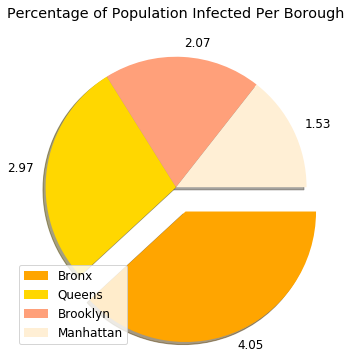

In [58]:
import matplotlib.pyplot as plt
 
values = [4.05,2.97,2.07,1.53]
colors = ['orange','gold','lightsalmon','papayawhip']
labels = ['Bronx','Queens','Brooklyn','Manhattan']
explode = (0.2, 0, 0, 0)
fig = plt.figure(1, figsize=(6,6))
plt.pie(values, colors=colors, labels= values,explode=explode,counterclock=False, shadow=True)
plt.title('Percentage of Population Infected Per Borough')
plt.legend(labels,loc=3)
plt.show()

### Let see on a chart the number of bed types with the number of Covid-19 infected people in each Borough.

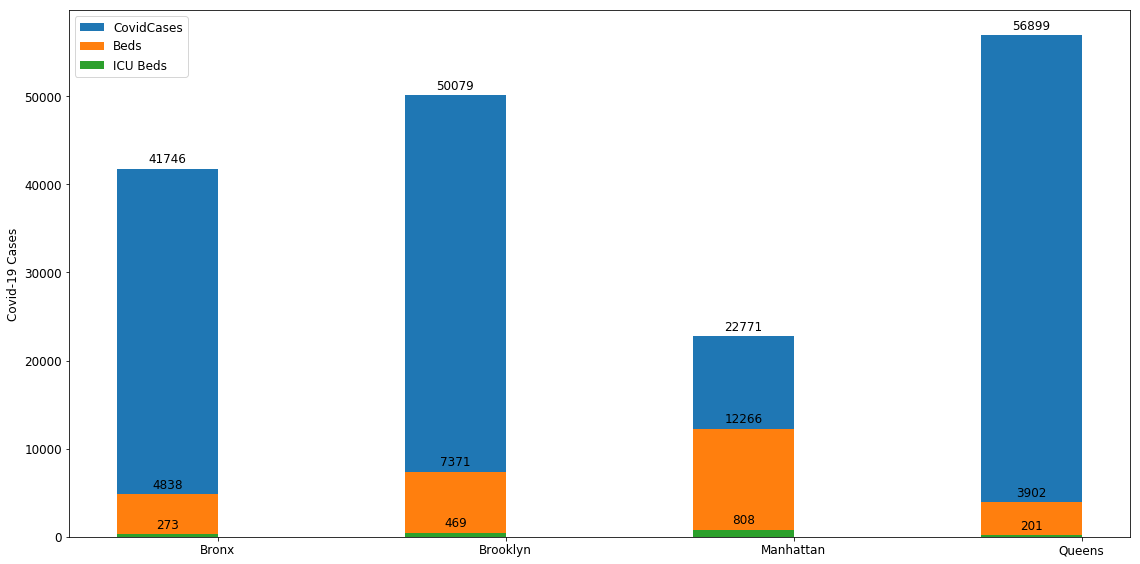

In [59]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens']
CovidCases = [41746,50079,22771,56899]
Beds = [4838,7371,12266,3902]
ICU_Beds = [273,469,808,201]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, CovidCases, width, label='CovidCases')
rects2 = ax.bar(x - width/2, Beds, width, label='Beds')
rects3 = ax.bar(x - width/2, ICU_Beds, width, label='ICU Beds')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Covid-19 Cases')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

### We can see from the chart that Manhattan seems to be the Borough the best equipped to deal with Covid-19 infected cases. Let's confirm our observation by looking at the percentage of total beds available compared to the number of infected people.

In [60]:
data = {'Borough':  ['Bronx','Brooklyn','Manhattan','Queens'],
        'Total Beds': ['5111', '7840','13074','4103'],
        'Percent_Beds_Available': ['8.17', '15.66','57.42','7.21']
        }

df = pd.DataFrame (data, columns = ['Borough','Total Beds','Percent_Beds_Available'])
df

,Borough,Total Beds,Percent_Beds_Available
0,Bronx,5111,8.17
1,Brooklyn,7840,15.66
2,Manhattan,13074,57.42
3,Queens,4103,7.21


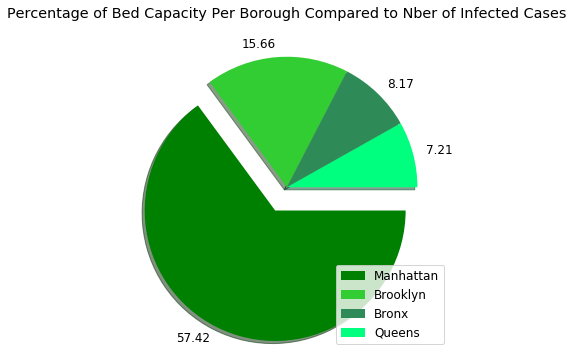

In [61]:
import matplotlib.pyplot as plt
 
values = [57.42,15.66,8.17,7.21]
colors = ['green','limegreen','seagreen','springgreen']
labels = ['Manhattan','Brooklyn','Bronx','Queens']
explode = (0.2, 0, 0, 0)
fig = plt.figure(1, figsize=(6,6))
plt.pie(values, colors=colors, labels= values,explode=explode,counterclock=False, shadow=True)
plt.title('Percentage of Bed Capacity Per Borough Compared to Nber of Infected Cases')
plt.legend(labels,loc=4)
plt.show()

### Therefore, from the pie chart, we can confirm that the best equiped Borough in terms of beds capacity to welcome Covid-19 infected People is Manhattan, followed by Brooklyn, The Bronx and The Queens.

### _This is the end of our analysis_